In [1]:
# Intel extension to improve performance of certain scikit-learn functions.
# This can be left out if unavailable on your device.
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data prep

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Global variables (iterations, trained model storage path)
iters = 50
dirname = 'lung_cancer_1_2_3'

In [4]:
# Load training data
train_df = pd.read_csv('c_nc_dataset_lung_loo1_2_3.dat', sep=' ')
batch = train_df.pop('Batch')

In [5]:
train_df

,1,10,100,1000,10000,100009676,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
GSM475656.CEL.gz,5.745587,4.616206,6.629331,9.352395,8.714538,4.839322,6.761428,5.229821,3.195876,8.951559,...,10.867989,8.236366,9.811042,10.634556,7.419433,10.443271,4.436031,8.724955,6.849980,8.292077
GSM475657.CEL.gz,5.474977,4.715683,6.326979,5.201489,7.986143,4.722360,7.063102,4.502396,3.936451,7.879865,...,11.152183,8.841301,10.295648,10.472007,8.931885,10.580142,4.648615,8.801190,6.772492,7.727589
GSM475658.CEL.gz,5.485601,4.521382,6.244910,5.368789,8.829572,4.866263,7.565211,4.492835,4.080016,8.254964,...,11.130777,8.504756,10.293572,10.335137,8.546757,10.539670,4.505812,8.670697,6.714413,7.605968
GSM475659.CEL.gz,5.765986,4.663024,6.662437,5.202817,8.680433,4.630616,7.283477,4.554046,4.339555,8.104566,...,10.750150,8.785521,10.114282,10.401780,8.593096,10.652256,4.805411,8.813218,7.000396,7.572412
GSM475660.CEL.gz,5.439663,4.421768,5.803991,5.048390,7.733964,4.817224,7.233923,4.781845,3.274058,8.655435,...,10.828081,7.861787,10.069229,10.581234,8.800112,10.538199,4.880280,9.048731,6.509962,8.330542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM673915.CEL.gz,5.061790,4.274140,6.558862,4.990706,7.030888,5.453539,7.944736,4.734466,3.675005,9.032114,...,10.656380,9.027322,9.698453,11.412777,8.380202,11.245559,4.920598,8.813512,7.373423,8.162683
GSM673916.CEL.gz,5.730555,4.334032,7.274197,6.502467,8.097033,5.064699,7.566259,4.934052,4.319928,8.376677,...,11.059836,8.501673,10.419040,10.099665,8.594553,10.366736,4.781344,8.233612,6.731080,8.345995
GSM673917.CEL.gz,6.302643,4.114455,5.924844,5.313923,6.193212,5.465923,7.789929,4.829058,3.741287,8.444341,...,10.926174,8.067941,10.236130,11.376401,9.207642,11.132359,4.716700,8.474177,6.611188,8.058290
GSM673918.CEL.gz,5.689082,4.495515,6.525316,6.390629,8.270996,4.999010,7.678630,4.738761,4.641001,8.190720,...,10.840038,8.670212,9.852085,9.478371,8.638152,10.178215,4.762928,8.273069,7.171875,7.955345


In [6]:
# Load training labels
train_label_arr = []

# 19188 labels
with open('19188_txt.txt', 'r') as f:
    for line in f:
        c = line[-2]
        if c == 'u' or c == 'T':
            train_label_arr.append(1)
        else:
            train_label_arr.append(0)

# 19804 labels
train_label_arr += [1] * 60
train_label_arr += [0] * 60

# 27262 labels
# sample nos. 1, 3, etc. are healthy (0); 2, 4, etc. are cancerous (1) (adjusted here for 0 indexing)
train_label_arr += [i % 2 for i in range(50)]

train_label_arr = np.array(train_label_arr)

In [7]:
# Load testing data
test_df = pd.read_csv('c_nc_dataset_lung_loo4.dat', sep=' ')
test_df

,1,10,100,1000,10000,100009676,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
GSM1235016_Normal1.CEL.gz,5.701697,4.264322,7.056545,5.049114,7.416547,4.811396,7.734021,4.922616,3.748215,8.887146,...,11.034319,8.011669,9.297959,8.653950,8.531578,9.683877,4.796156,8.257759,6.336153,7.753834
GSM1235017_Tumor1.CEL.gz,6.304988,4.243543,8.355160,6.956865,8.337286,4.928133,8.091276,4.584026,3.328584,9.039359,...,10.676453,7.820797,9.834546,9.537279,8.255226,10.546292,4.557188,8.364088,7.070376,8.513537
GSM1235018_Normal2.CEL.gz,5.675319,4.120970,8.454500,4.856013,7.500562,4.892499,7.540503,4.779247,3.569497,8.881277,...,10.755557,8.406857,9.910477,10.555886,8.866512,10.861604,4.650703,8.465527,7.067046,8.856827
GSM1235019_Tumor2.CEL.gz,5.765385,3.983633,6.608461,5.278367,6.057135,5.014351,7.998972,5.067458,3.858031,8.342309,...,10.749952,8.961564,10.136627,11.397730,8.264711,10.705992,4.581430,8.623304,7.055871,8.722955
GSM1235020_Normal3.CEL.gz,5.494043,4.270688,6.878203,4.918952,7.504832,5.139371,7.337506,4.858368,3.689542,8.581465,...,10.809595,8.263967,10.515400,11.526839,8.224601,10.600563,4.842127,9.414287,7.143182,8.551732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1235107_Tumor39.CEL.gz,5.571533,4.347655,7.123081,5.476606,8.840101,4.855781,7.789891,4.755955,3.644366,8.927786,...,10.601187,8.670546,10.058858,10.894266,9.059532,10.784621,4.664324,9.036722,6.821337,9.184777
GSM1235108_Normal40.CEL.gz,5.199245,4.300748,6.102188,4.857487,7.643285,4.974794,8.120131,4.628532,3.502595,8.077970,...,11.104182,8.381064,10.236633,11.328067,8.768475,10.481933,4.788526,8.906542,7.399841,7.425271
GSM1235109_Tumor40.CEL.gz,6.205551,4.123354,6.888686,6.138436,7.940836,4.825950,7.666336,4.523173,3.680047,8.241734,...,10.672326,9.098001,9.726749,9.215259,8.287458,10.495661,4.676491,8.424335,8.149426,8.042008
GSM1235110_Normal41.CEL.gz,5.430663,4.240042,6.427244,4.835565,7.754040,4.937144,7.892961,4.533516,3.396541,8.137671,...,10.965681,8.324654,10.445956,11.501976,8.876149,10.635642,4.776030,8.996055,7.376958,8.299552


In [8]:
# Load testing labels
test_label_arr = []

# 51024 labels
with open('51024_txt.txt', 'r') as f:
    for line in f:
        if 'Normal' in line:
            test_label_arr.append(0)
        else:
            test_label_arr.append(1)

test_label_arr = np.array(test_label_arr)

In [9]:
# Correlation matrix
corr = train_df.corr().abs()
corr

,1,10,100,1000,10000,100009676,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
1,1.000000,0.130646,0.265397,0.206998,0.011711,0.118130,0.149497,0.147231,0.271496,0.174035,...,0.069233,0.145232,0.084742,0.075554,0.102523,0.075134,0.087742,0.057353,0.273113,0.122404
10,0.130646,1.000000,0.100240,0.066505,0.064920,0.048589,0.081281,0.084291,0.110971,0.051787,...,0.027283,0.057855,0.052713,0.015569,0.010543,0.056036,0.070344,0.011880,0.085628,0.096536
100,0.265397,0.100240,1.000000,0.236839,0.028806,0.021876,0.001603,0.045603,0.143033,0.133920,...,0.044556,0.026992,0.022136,0.279681,0.007595,0.123418,0.049704,0.225187,0.086612,0.298915
1000,0.206998,0.066505,0.236839,1.000000,0.209324,0.148481,0.007022,0.026936,0.000884,0.028176,...,0.052192,0.061302,0.146147,0.250217,0.094647,0.004113,0.014412,0.028664,0.065168,0.187543
10000,0.011711,0.064920,0.028806,0.209324,1.000000,0.226870,0.342874,0.112467,0.485825,0.341015,...,0.465921,0.065337,0.216445,0.493753,0.263254,0.001732,0.159709,0.017174,0.110789,0.337860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,0.075134,0.056036,0.123418,0.004113,0.001732,0.085929,0.196355,0.077678,0.201692,0.047582,...,0.048861,0.046342,0.037026,0.265134,0.204359,1.000000,0.134675,0.052322,0.010439,0.115054
9992,0.087742,0.070344,0.049704,0.014412,0.159709,0.039828,0.038737,0.156489,0.183422,0.052647,...,0.053520,0.015961,0.122520,0.083032,0.143330,0.134675,1.000000,0.008847,0.050568,0.019136
9993,0.057353,0.011880,0.225187,0.028664,0.017174,0.000617,0.385923,0.148985,0.084132,0.166016,...,0.071669,0.104322,0.101236,0.195258,0.017554,0.052322,0.008847,1.000000,0.298960,0.005929
9994,0.273113,0.085628,0.086612,0.065168,0.110789,0.055309,0.513736,0.317220,0.219866,0.050176,...,0.100038,0.377321,0.170200,0.026923,0.165655,0.010439,0.050568,0.298960,1.000000,0.286233


In [10]:
# Upper triangular of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
upper

,1,10,100,1000,10000,100009676,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
1,NaN,0.130646,0.265397,0.206998,0.011711,0.118130,0.149497,0.147231,0.271496,0.174035,...,0.069233,0.145232,0.084742,0.075554,0.102523,0.075134,0.087742,0.057353,0.273113,0.122404
10,NaN,NaN,0.100240,0.066505,0.064920,0.048589,0.081281,0.084291,0.110971,0.051787,...,0.027283,0.057855,0.052713,0.015569,0.010543,0.056036,0.070344,0.011880,0.085628,0.096536
100,NaN,NaN,NaN,0.236839,0.028806,0.021876,0.001603,0.045603,0.143033,0.133920,...,0.044556,0.026992,0.022136,0.279681,0.007595,0.123418,0.049704,0.225187,0.086612,0.298915
1000,NaN,NaN,NaN,NaN,0.209324,0.148481,0.007022,0.026936,0.000884,0.028176,...,0.052192,0.061302,0.146147,0.250217,0.094647,0.004113,0.014412,0.028664,0.065168,0.187543
10000,NaN,NaN,NaN,NaN,NaN,0.226870,0.342874,0.112467,0.485825,0.341015,...,0.465921,0.065337,0.216445,0.493753,0.263254,0.001732,0.159709,0.017174,0.110789,0.337860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.134675,0.052322,0.010439,0.115054
9992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008847,0.050568,0.019136
9993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.298960,0.005929
9994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286233


In [11]:
# Identify highly correlated features
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
len(to_drop)

787

In [12]:
# Drop highly correlated features
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

In [13]:
# Initiate recursive feature elimination with random forest
rfe_pre = RFE(estimator=RandomForestClassifier(), step=.001, n_features_to_select=300, verbose=1)
selector_pre = rfe_pre.fit(train_df, train_label_arr)

Fitting estimator with 18569 features.
Fitting estimator with 18551 features.
Fitting estimator with 18533 features.
Fitting estimator with 18515 features.
Fitting estimator with 18497 features.
Fitting estimator with 18479 features.
Fitting estimator with 18461 features.
Fitting estimator with 18443 features.
Fitting estimator with 18425 features.
Fitting estimator with 18407 features.
Fitting estimator with 18389 features.
Fitting estimator with 18371 features.
Fitting estimator with 18353 features.
Fitting estimator with 18335 features.
Fitting estimator with 18317 features.
Fitting estimator with 18299 features.
Fitting estimator with 18281 features.
Fitting estimator with 18263 features.
Fitting estimator with 18245 features.
Fitting estimator with 18227 features.
Fitting estimator with 18209 features.
Fitting estimator with 18191 features.
Fitting estimator with 18173 features.
Fitting estimator with 18155 features.
Fitting estimator with 18137 features.
Fitting estimator with 18

In [14]:
# Preserve top 300 features
filtered_train_df_pre = train_df.loc[:, selector_pre.support_]
filtered_test_df_pre = test_df.loc[:, selector_pre.support_]

In [15]:
# Cull from 300 to 50
rfe50 = RFE(estimator=RandomForestClassifier(), n_features_to_select=50)
selector50 = rfe50.fit(filtered_train_df_pre, train_label_arr)

In [16]:
# Preserve top 50 features
filtered_train_df_50 = filtered_train_df_pre.loc[:, selector50.support_]
filtered_train_df_50_arr = np.array(filtered_train_df_50)
filtered_test_df_50 = filtered_test_df_pre.loc[:, selector50.support_]
filtered_test_df_50_arr = np.array(filtered_test_df_50)

In [17]:
# Cull from 50 to 20
rfe20 = RFE(estimator=RandomForestClassifier(), n_features_to_select=20)
selector20 = rfe20.fit(filtered_train_df_50, train_label_arr)

In [18]:
# Preserve top 20 features
filtered_train_df_20 = filtered_train_df_50.loc[:, selector20.support_]
filtered_train_df_20_arr = np.array(filtered_train_df_20)
filtered_test_df_20 = filtered_test_df_50.loc[:, selector20.support_]
filtered_test_df_20_arr = np.array(filtered_test_df_20)

# Simple classifiers

In [19]:
from sklearn.metrics import precision_recall_fscore_support as prfs, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
import matplotlib.pyplot as plt
import joblib
import os

In [20]:
# Function for testing for data leakage (compare each row in train to each row in test, and returns true if identical match is found)
def leakage(train, test):
    for i in train:
        for j in test:
            if (i == j).all():
                return True
            return False

## Decision tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

### Training models on 20 features

In [22]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]

dc20means = [] # Means of i models trained 
dc20vars = []  # Variances of i models trained
for p in percents:
    avg_score_per_depth=[] # Store scores of models trained from depth 2 to 10
    for i in range(iters):
        
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_20_arr_pct)
        
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_20_arr_pct), ss.transform(filtered_test_df_20_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for max_depth in range(2, 11):
            # Build and fit model, then gather predictions
            clf = DecisionTreeClassifier(max_depth=max_depth)
            clf.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct)
            preds = clf.predict(ss.transform(filtered_test_df_20_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])

        # Store the scores for the current iteration of models with max_depth 2 to 10
        avg_score_per_depth.append(scores)
        
    avg_score_per_depth = np.array(avg_score_per_depth)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_depth, axis=0).T)
    # Store these values for plotting
    dc20means.append(np.mean(avg_score_per_depth, axis=0))
    dc20vars.append(np.var(avg_score_per_depth, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.88541667 0.83770833 0.85208333 0.854375   0.84520833 0.84520833
  0.8475     0.845625   0.84270833]
 [0.86666667 0.86563481 0.87156761 0.87597415 0.85850739 0.86031624
  0.85849337 0.86223051 0.85509511]
 [0.94545455 0.84945455 0.87054545 0.86945455 0.87454545 0.872
  0.87963636 0.87018182 0.87418182]
 [0.90434783 0.85709786 0.87085927 0.87246765 0.86623692 0.86588844
  0.86865339 0.86592093 0.86430211]]

Percent of training data used: 0.9
50 runs average score: 
[[0.88083333 0.86395833 0.87229167 0.86458333 0.86270833 0.86270833
  0.86125    0.85875    0.86020833]
 [0.86296223 0.87267478 0.86840361 0.86788187 0.86250575 0.86042457
  0.85613847 0.85723916 0.85649842]
 [0.94290909 0.89454545 0.91709091 0.90254545 0.90654545 0.90945455
  0.91309091 0.90763636 0.90981818]
 [0.9007102  0.88245427 0.89155279 0.88417488 0.88331099 0.88358269
  0.88297135 0.88066365 0.88178602]]

Percent of training data used: 0.8
50 runs average sc

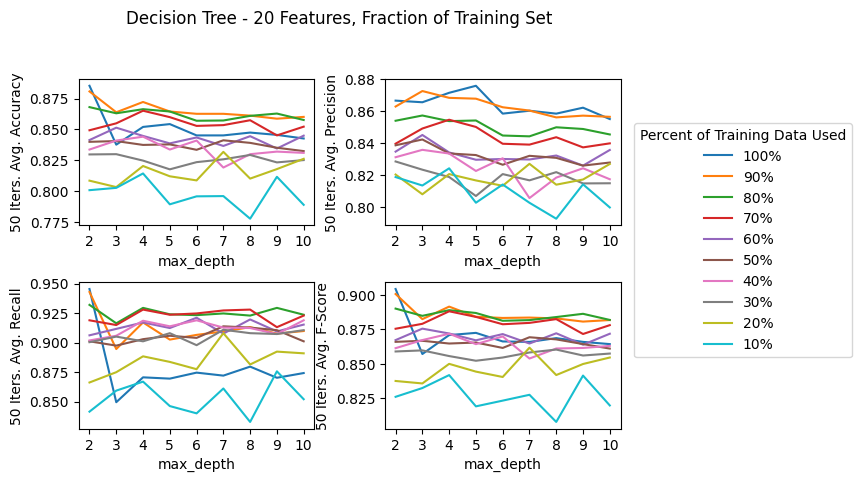

In [23]:
plot = dc20means

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('Decision Tree - 20 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 9), range(2, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 9), range(2, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 9), range(2, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 9), range(2, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [24]:
print(dc20vars)

[array([[4.93038066e-32, 1.10933565e-31, 0.00000000e+00, 1.23259516e-30],
       [3.30251736e-04, 5.99575975e-04, 5.42677686e-04, 2.43111355e-04],
       [1.86631944e-04, 3.04317405e-04, 3.12595041e-04, 1.39185551e-04],
       [1.32335069e-04, 2.99259516e-04, 3.00033058e-04, 9.69591425e-05],
       [2.25737847e-04, 3.91009820e-04, 2.80991736e-04, 1.53792886e-04],
       [3.03862847e-04, 4.56312145e-04, 3.69719008e-04, 2.15685473e-04],
       [2.11631944e-04, 4.74219083e-04, 2.63008264e-04, 1.32016031e-04],
       [2.28689236e-04, 3.69575815e-04, 4.23272727e-04, 1.69183536e-04],
       [2.05078125e-04, 3.66453183e-04, 3.15239669e-04, 1.43633981e-04]]), array([[0.00181927, 0.00154458, 0.00174559, 0.00122728],
       [0.0008872 , 0.0009131 , 0.00232727, 0.00072798],
       [0.00095404, 0.00093388, 0.00141699, 0.00069731],
       [0.00104601, 0.0011808 , 0.00155716, 0.00075444],
       [0.00089709, 0.00114098, 0.00120344, 0.00061206],
       [0.00095786, 0.00114467, 0.00140813, 0.0006736 ]

### Training models on 50 features

In [25]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]

dc50means = [] # Means of i models trained 
dc50vars = []  # Variances of i models trained
for p in percents:
    avg_score_per_depth=[] # Store scores of models trained from depth 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_50_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_50_arr_pct), ss.transform(filtered_test_df_50_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for max_depth in range(2, 11):
            # Build and fit model, then gather predictions
            clf = DecisionTreeClassifier(max_depth=max_depth)
            clf.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct)
            preds = clf.predict(ss.transform(filtered_test_df_50_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
            
        # Store the scores for the current iteration of models with max_depth 2 to 10
        avg_score_per_depth.append(scores)
        
    avg_score_per_depth = np.array(avg_score_per_depth)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_depth, axis=0).T)
    # Store these values for plotting
    dc50means.append(np.mean(avg_score_per_depth, axis=0))
    dc50vars.append(np.var(avg_score_per_depth, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.88541667 0.87333333 0.868125   0.854375   0.85916667 0.86125
  0.86       0.85833333 0.85416667]
 [0.86666667 0.88239234 0.87363583 0.85427699 0.86150982 0.86365116
  0.86255904 0.86013894 0.85513119]
 [0.94545455 0.89927273 0.90109091 0.90072727 0.89963636 0.90109091
  0.9        0.9        0.89890909]
 [0.90434783 0.89068182 0.88698942 0.87665982 0.88001339 0.88179921
  0.88071276 0.87945501 0.87626571]]

Percent of training data used: 0.9
50 runs average score: 
[[0.85583333 0.84291667 0.84333333 0.840625   0.825      0.83416667
  0.8325     0.83770833 0.83645833]
 [0.85013584 0.84707505 0.84202696 0.83646314 0.82079508 0.83176042
  0.82533963 0.83400867 0.83148271]
 [0.912      0.89090909 0.89963636 0.90218182 0.89454545 0.89745455
  0.90472727 0.90327273 0.89963636]
 [0.87886757 0.86698274 0.86845095 0.86685091 0.85475822 0.86176001
  0.86155762 0.86550108 0.86314831]]

Percent of training data used: 0.8
50 runs average 

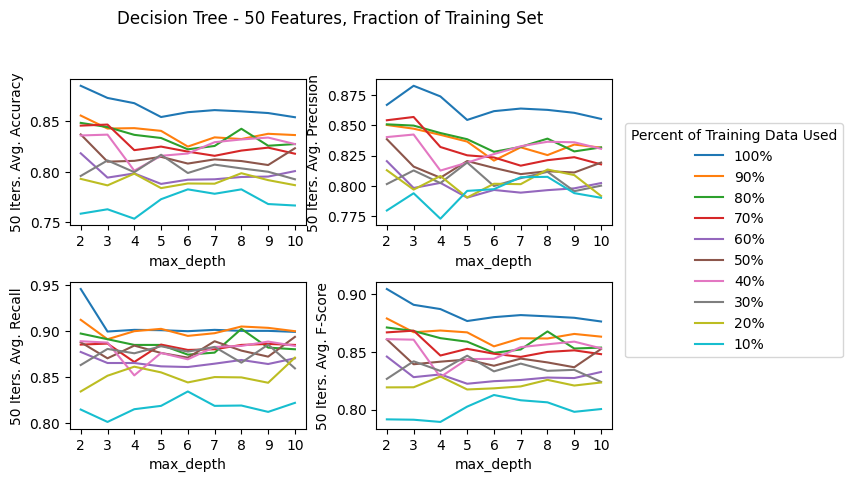

In [26]:
plot = dc50means

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('Decision Tree - 50 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 9), range(2, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 9), range(2, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 9), range(2, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 9), range(2, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [27]:
print(dc50vars)

[array([[4.93038066e-32, 1.10933565e-31, 0.00000000e+00, 1.23259516e-30],
       [4.31250000e-04, 6.07211373e-04, 8.21157025e-05, 2.88688017e-04],
       [5.79904514e-04, 8.81266604e-04, 8.14545455e-05, 3.63080976e-04],
       [6.83550347e-04, 1.04564629e-03, 8.21157025e-05, 4.07709263e-04],
       [5.08854167e-04, 7.70564191e-04, 8.25123967e-05, 3.18924256e-04],
       [6.09548611e-04, 9.14086280e-04, 8.14545455e-05, 3.74979419e-04],
       [5.64930556e-04, 8.53961377e-04, 8.26446281e-05, 3.48010611e-04],
       [5.55555556e-04, 8.29819129e-04, 8.26446281e-05, 3.41594223e-04],
       [6.51041667e-04, 9.99074454e-04, 8.14545455e-05, 3.94530997e-04]]), array([[0.00198507, 0.00224132, 0.00235848, 0.00136578],
       [0.00322847, 0.00372915, 0.00313388, 0.0022115 ],
       [0.00224375, 0.00293306, 0.002304  , 0.00145624],
       [0.00194553, 0.00272086, 0.00181012, 0.00123032],
       [0.00202691, 0.00285918, 0.00157355, 0.00117791],
       [0.00235608, 0.00333261, 0.00199352, 0.00140203]

## Random forest

### Training models on 20 features

In [28]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
rf20means = [] # Means of i models trained 
rf20vars = []  # Variances of i models trained
for p in percents:
    avg_score_per_depth=[] # Store scores of models trained from depth 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_20_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_20_arr_pct), ss.transform(filtered_test_df_20_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for max_depth in range(2, 11):
            # Unique path to store models
            path = f'pkls/{dirname}/rf20/train_{p*100:.0f}/iter_{i+1}/max_depth_{max_depth}.pkl'
            
            if os.path.exists(path):
                # Load up trained model if one exists to save time and prevent reconstruction and retraining
                clf = joblib.load(path)
            else:
                # Build and fit model
                clf = RandomForestClassifier(max_depth=max_depth)
                clf.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct)
            
            # Gather predictions
            preds = clf.predict(ss.transform(filtered_test_df_20_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
            
            # Save trained model to disk if one doesn't exist
            if not os.path.exists(path):
                os.makedirs(os.path.dirname(path), exist_ok=True)
                joblib.dump(clf, path, compress=3)
        
        # Store the scores for the current iteration of models with max_depth 2 to 10
        avg_score_per_depth.append(scores)
    
    avg_score_per_depth = np.array(avg_score_per_depth)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_depth, axis=0).T)
    # Store these values for plotting
    rf20means.append(np.mean(avg_score_per_depth, axis=0))
    rf20vars.append(np.var(avg_score_per_depth, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.918125   0.92145833 0.916875   0.91854167 0.92125    0.91979167
  0.91875    0.92708333 0.91770833]
 [0.88775901 0.89164824 0.88702119 0.88783597 0.89338906 0.89007871
  0.88694556 0.898096   0.88745163]
 [0.98218182 0.98327273 0.98036364 0.98290909 0.98       0.98218182
  0.98436364 0.98509091 0.98145455]
 [0.93238392 0.93498976 0.93123124 0.93274473 0.9345701  0.93365152
  0.93295087 0.93943182 0.9319331 ]]

Percent of training data used: 0.9
50 runs average score: 
[[0.91895833 0.920625   0.923125   0.92375    0.92083333 0.925625
  0.920625   0.92770833 0.91895833]
 [0.89024993 0.89174551 0.89547621 0.89348428 0.89287843 0.89613271
  0.8908795  0.89940183 0.88991   ]
 [0.98036364 0.98145455 0.98109091 0.98509091 0.98036364 0.98509091
  0.98254545 0.98436364 0.98036364]
 [0.93293052 0.93424443 0.93613974 0.93686418 0.93436986 0.93830992
  0.934302   0.93984755 0.93280109]]

Percent of training data used: 0.8
50 runs average

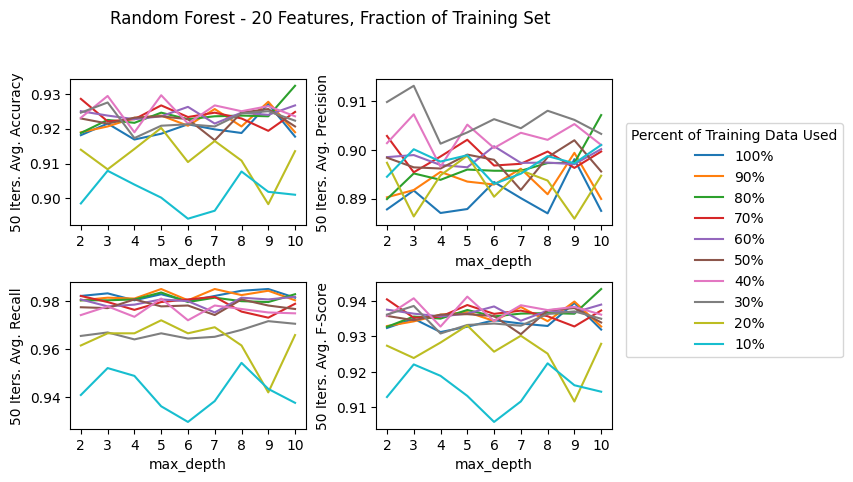

In [29]:
plot = rf20means
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('Random Forest - 20 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 9), range(2, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 9), range(2, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 9), range(2, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 9), range(2, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [30]:
print(rf20vars)

[array([[3.95008681e-04, 6.79123242e-04, 8.58181818e-05, 2.42266344e-04],
       [2.87369792e-04, 5.81551045e-04, 1.30115702e-04, 1.75423554e-04],
       [2.92925347e-04, 4.66149401e-04, 7.72231405e-05, 1.82484629e-04],
       [4.80425347e-04, 7.20538262e-04, 1.77322314e-04, 2.99171797e-04],
       [2.61111111e-04, 4.05473799e-04, 1.09090909e-04, 1.66016383e-04],
       [3.35286458e-04, 6.14767365e-04, 9.90413223e-05, 2.01981895e-04],
       [3.99305556e-04, 5.61760541e-04, 1.72033058e-04, 2.47419454e-04],
       [2.64756944e-04, 4.41450282e-04, 1.28132231e-04, 1.67460180e-04],
       [2.26779514e-04, 4.26120455e-04, 8.58181818e-05, 1.38478877e-04]]), array([[4.35286458e-04, 7.33010935e-04, 7.72231405e-05, 2.65990278e-04],
       [4.63932292e-04, 6.64618728e-04, 2.04826446e-04, 2.85042289e-04],
       [3.16362847e-04, 5.58151555e-04, 1.31702479e-04, 1.98567224e-04],
       [2.79687500e-04, 5.19453699e-04, 1.14909091e-04, 1.72568147e-04],
       [4.21006944e-04, 7.03377456e-04, 1.036694

### Training models on 50 features

In [31]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
rf50means = [] # Means of i models trained 
rf50vars = []  # Variances of i models trained

for p in percents:
    avg_score_per_depth=[] # Store scores of models trained from depth 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_50_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_50_arr_pct), ss.transform(filtered_test_df_50_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for max_depth in range(2, 11):
            # Unique path to store models
            path = f'pkls/{dirname}/rf50/train_{p*100:.0f}/iter_{i+1}/max_depth_{max_depth}.pkl'
            
            if os.path.exists(path):
                # Load up trained model if one exists to save time and prevent reconstruction and retraining
                clf = joblib.load(path)
            else:
                # Build and fit model
                clf = RandomForestClassifier(max_depth=max_depth)
                clf.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct)
            
            # Gather predictions
            preds = clf.predict(ss.transform(filtered_test_df_50_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
            
            # Save trained model to disk if one doesn't exist
            if not os.path.exists(path):
                os.makedirs(os.path.dirname(path), exist_ok=True)
                joblib.dump(clf, path, compress=3)
        
        # Store the scores for the current iteration of models with max_depth 2 to 10
        avg_score_per_depth.append(scores)
    
    avg_score_per_depth = np.array(avg_score_per_depth)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    # Store these values for plotting
    print(np.mean(avg_score_per_depth, axis=0).T)
    rf50means.append(np.mean(avg_score_per_depth, axis=0))
    rf50vars.append(np.var(avg_score_per_depth, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.92395833 0.925      0.928125   0.929375   0.92833333 0.928125
  0.926875   0.92791667 0.92458333]
 [0.89049406 0.89192249 0.89654874 0.89699668 0.89819218 0.89601178
  0.89476466 0.89593518 0.89212909]
 [0.98945455 0.98945455 0.98909091 0.99090909 0.98727273 0.98981818
  0.98945455 0.98945455 0.98836364]
 [0.93725097 0.93804443 0.9404454  0.94152275 0.94052006 0.94048509
  0.9395663  0.94029756 0.93765074]]

Percent of training data used: 0.9
50 runs average score: 
[[0.93125    0.92625    0.92729167 0.92833333 0.92895833 0.92833333
  0.92895833 0.92666667 0.930625  ]
 [0.90182491 0.8961672  0.89603122 0.89812552 0.89857686 0.89655217
  0.90096369 0.89410071 0.89973226]
 [0.988      0.98618182 0.988      0.98763636 0.98836364 0.98945455
  0.98472727 0.98981818 0.98981818]
 [0.94283    0.93883561 0.93968885 0.94057069 0.94112106 0.94061745
  0.94084488 0.93938955 0.94248837]]

Percent of training data used: 0.8
50 runs average

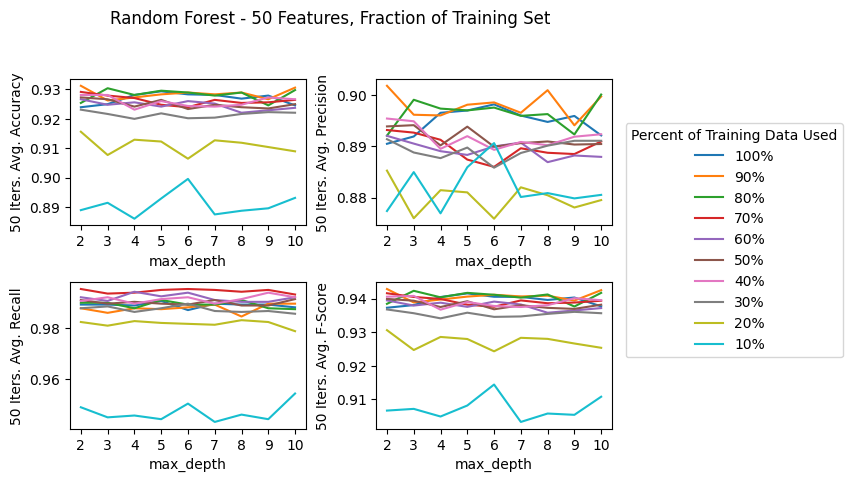

In [32]:
plot = rf50means
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('Random Forest - 50 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 9), range(2, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 9), range(2, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 9), range(2, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 9), range(2, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [33]:
print(rf50vars)

[array([[2.70182292e-04, 4.02606235e-04, 1.06975207e-04, 1.69823493e-04],
       [2.34375000e-04, 3.64289426e-04, 1.06975207e-04, 1.48442497e-04],
       [2.05078125e-04, 3.21795523e-04, 9.25619835e-05, 1.29629667e-04],
       [2.05251736e-04, 3.16421190e-04, 8.26446281e-05, 1.30292398e-04],
       [2.63194444e-04, 3.81472092e-04, 1.09090909e-04, 1.67111416e-04],
       [2.13758681e-04, 3.22551769e-04, 9.46776860e-05, 1.36552835e-04],
       [3.14626736e-04, 5.33283339e-04, 8.05289256e-05, 1.92537345e-04],
       [2.64062500e-04, 3.31142960e-04, 1.20198347e-04, 1.70399478e-04],
       [2.19444444e-04, 3.59661839e-04, 1.29057851e-04, 1.38978582e-04]]), array([[2.12673611e-04, 3.46905195e-04, 1.13851240e-04, 1.36694065e-04],
       [2.55381944e-04, 4.49954519e-04, 1.79305785e-04, 1.62177948e-04],
       [1.36675347e-04, 2.01631311e-04, 1.13851240e-04, 8.88983142e-05],
       [2.37152778e-04, 4.65052581e-04, 1.11603306e-04, 1.44621895e-04],
       [2.63411458e-04, 5.35222027e-04, 1.158347

## SVC

In [34]:
from sklearn.svm import SVC

### Training models on 20 features

In [35]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
svm20means=[] # Means of i models trained 
svm20vars = []  # Variances of i models trained

for p in percents:
    avg_svc_acc=[] # Store scores of models trained
    for i in range(iters):
        if p == 1:
             # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
        
        # Unique path to store models
        path = f'pkls/{dirname}/svc20/train_{p*100:.0f}/iter_{i+1}.pkl'
        ss = StandardScaler()
        ss.fit(train_df_20_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_20_arr_pct), ss.transform(filtered_test_df_20_arr))
        
        if os.path.exists(path):
            # Load up trained model if one exists to save time and prevent reconstruction and retraining
            clf = joblib.load(path)
        else:
            # Build and fit model
            pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
            params = [{'svc__C':[10**x for x in range(-2, 10)], 'svc__gamma':[10**x for x in range(-5, 4)]}]
            clf = GridSearchCV(pipeline, params)
            clf.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct)

            clf = SVC(C=clf.best_params_['svc__C'], gamma=clf.best_params_['svc__gamma'])
            clf.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct)
        
        # Gather predictions
        preds = clf.predict(ss.transform(filtered_test_df_20_arr))
        
        # Gather precision, recall, and f1 score from predictions
        score = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
        
        # Store these values along with accuracy for this model
        avg_svc_acc.append([accuracy_score(test_label_arr, preds), score[0], score[1], score[2]])
        #print(i + 1, end=' ')
        
        # Save trained model to disk if one doesn't exist
        if not os.path.exists(path):
            os.makedirs(os.path.dirname(path), exist_ok=True)
            joblib.dump(clf, path, compress=3)
        
        # No variance in SVM if complete training data is used, so no need to go extra iterations
        if p == 1:
            break
    
    avg_svc_acc = np.array(avg_svc_acc)
    print()
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    # Store these values for plotting
    print(np.mean(avg_svc_acc, axis=0))
    svm20means.append(np.mean(avg_svc_acc, axis=0))
    svm20vars.append(np.var(avg_svc_acc, axis=0))
    print()


Percent of training data used: 1
50 runs average score: 
[0.77083333 0.7704918  0.85454545 0.81034483]


Percent of training data used: 0.9
50 runs average score: 
[0.91895833 0.88489325 0.988      0.9333516 ]


Percent of training data used: 0.8
50 runs average score: 
[0.91416667 0.87889162 0.98836364 0.92993187]


Percent of training data used: 0.7
50 runs average score: 
[0.91604167 0.88414724 0.98363636 0.93087582]


Percent of training data used: 0.6
50 runs average score: 
[0.915625   0.88604259 0.98145455 0.93063692]


Percent of training data used: 0.5
50 runs average score: 
[0.91375    0.88274649 0.98327273 0.92950588]


Percent of training data used: 0.4
50 runs average score: 
[0.91791667 0.89923373 0.96872727 0.93169474]


Percent of training data used: 0.3
50 runs average score: 
[0.91916667 0.89519593 0.976      0.93295314]


Percent of training data used: 0.2
50 runs average score: 
[0.91729167 0.89778569 0.972      0.93165532]


Percent of training data used: 0.1
50 

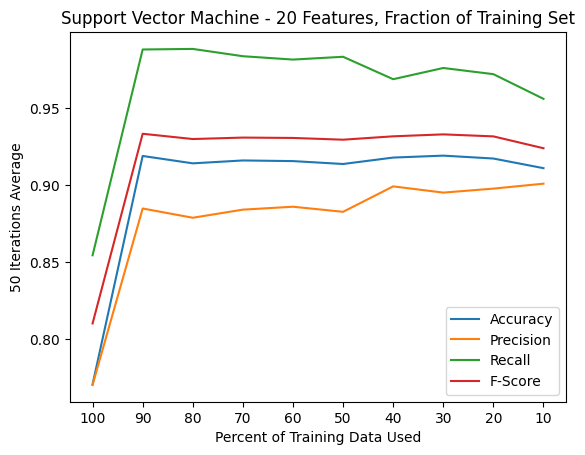

In [36]:
plt.plot(np.array(svm20means)[:,0], label='Accuracy')
plt.plot(np.array(svm20means)[:,1], label='Precision')
plt.plot(np.array(svm20means)[:,2], label='Recall')
plt.plot(np.array(svm20means)[:,3], label='F-Score')
plt.xticks(range(0, 10), [x*10 for x in range(10, 0, -1)])
plt.xlabel('Percent of Training Data Used')
plt.ylabel('50 Iterations Average')
plt.title('Support Vector Machine - 20 Features, Fraction of Training Set')
plt.legend()
plt.show()

In [37]:
print(svm20vars)

[array([0., 0., 0., 0.]), array([0.00020959, 0.00051376, 0.00011385, 0.00011608]), array([0.0005276 , 0.00114354, 0.00011583, 0.00028825]), array([0.00031862, 0.00073561, 0.00021488, 0.00018561]), array([0.00054796, 0.0013625 , 0.0002445 , 0.00029493]), array([0.00088993, 0.00183589, 0.0002359 , 0.00047743]), array([0.00104444, 0.00212208, 0.00067491, 0.00060292]), array([0.00050156, 0.00147016, 0.00058764, 0.00028247]), array([0.00126914, 0.00303941, 0.00112674, 0.00070034]), array([0.00202782, 0.00283718, 0.00605739, 0.00201234])]


### Training models on 50 features

In [38]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
svm50means=[] # Means of i models trained 
svm50vars = []  # Variances of i models trained

for p in percents:
    avg_svc_acc=[] # Store scores of models trained
    for i in range(iters):
        if p == 1:
             # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
        
        # Unique path to store models
        path = f'pkls/{dirname}/svc50/train_{p*100:.0f}/iter_{i+1}.pkl'
        ss = StandardScaler()
        ss.fit(train_df_50_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_50_arr_pct), ss.transform(filtered_test_df_50_arr))
        
        if os.path.exists(path):
            # Load up trained model if one exists to save time and prevent reconstruction and retraining
            clf = joblib.load(path)
        else:
            # Build and fit model
            pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
            params = [{'svc__C':[10**x for x in range(-2, 10)], 'svc__gamma':[10**x for x in range(-5, 4)]}]
            clf = GridSearchCV(pipeline, params)
            clf.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct)

            clf = SVC(C=clf.best_params_['svc__C'], gamma=clf.best_params_['svc__gamma'])
            clf.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct)
        
        # Gather predictions
        preds = clf.predict(ss.transform(filtered_test_df_50_arr))
        
        # Gather precision, recall, and f1 score from predictions
        score = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
        
        # Store these values along with accuracy for this model
        avg_svc_acc.append([accuracy_score(test_label_arr, preds), score[0], score[1], score[2]])
        #print(i + 1, end=' ')
        
        # Save trained model to disk if one doesn't exist
        if not os.path.exists(path):
            os.makedirs(os.path.dirname(path), exist_ok=True)
            joblib.dump(clf, path, compress=3)
        
        # No variance in SVM if complete training data is used, so no need to go extra iterations
        if p == 1:
            break
    
    avg_svc_acc = np.array(avg_svc_acc)
    print()
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    # Store these values for plotting
    print(np.mean(avg_svc_acc, axis=0))
    svm50means.append(np.mean(avg_svc_acc, axis=0))
    svm50vars.append(np.var(avg_svc_acc, axis=0))
    print()


Percent of training data used: 1
50 runs average score: 
[0.9375     0.90163934 1.         0.94827586]


Percent of training data used: 0.9
50 runs average score: 
[0.926875   0.90291309 0.97781818 0.93871106]


Percent of training data used: 0.8
50 runs average score: 
[0.92770833 0.91106488 0.96872727 0.93886694]


Percent of training data used: 0.7
50 runs average score: 
[0.92604167 0.90899636 0.96836364 0.93744859]


Percent of training data used: 0.6
50 runs average score: 
[0.92770833 0.90911591 0.972      0.9389943 ]


Percent of training data used: 0.5
50 runs average score: 
[0.92583333 0.90581541 0.97272727 0.93758981]


Percent of training data used: 0.4
50 runs average score: 
[0.925625   0.90130465 0.97818182 0.93777453]


Percent of training data used: 0.3
50 runs average score: 
[0.92416667 0.90564527 0.96981818 0.93600633]


Percent of training data used: 0.2
50 runs average score: 
[0.91958333 0.90343421 0.96690909 0.93263627]


Percent of training data used: 0.1
50 

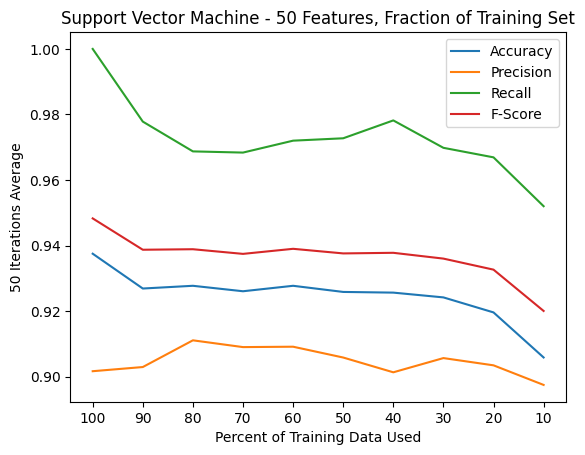

In [39]:
plt.plot(np.array(svm50means)[:,0], label='Accuracy')
plt.plot(np.array(svm50means)[:,1], label='Precision')
plt.plot(np.array(svm50means)[:,2], label='Recall')
plt.plot(np.array(svm50means)[:,3], label='F-Score')
plt.xticks(range(0, 10), [x*10 for x in range(10, 0, -1)])
plt.xlabel('Percent of Training Data Used')
plt.ylabel('50 Iterations Average')
plt.title('Support Vector Machine - 50 Features, Fraction of Training Set')
plt.legend()
plt.show()

In [40]:
print(svm50vars)

[array([0., 0., 0., 0.]), array([5.42100694e-05, 1.32827872e-04, 2.68297521e-04, 4.05860909e-05]), array([7.55642361e-05, 1.88586535e-04, 1.85652893e-04, 5.19994902e-05]), array([0.0001747 , 0.0002651 , 0.00057931, 0.00013606]), array([7.55642361e-05, 3.92058333e-04, 7.03603306e-04, 5.99132274e-05]), array([1.32986111e-04, 4.60442558e-04, 6.51239669e-04, 9.62908116e-05]), array([1.08550347e-04, 3.90887866e-04, 5.02479339e-04, 7.37927625e-05]), array([0.00011302, 0.00043198, 0.00093369, 0.00010202]), array([0.00085087, 0.00178701, 0.00150334, 0.00045697]), array([0.00184878, 0.00310133, 0.00577534, 0.00147707])]


## XGBoost

In [41]:
import xgboost as xgb
import random

### Training models on 20 features

In [42]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
xgb20means = [] # Means of i models trained 
xgb20vars = []  # Variances of i models trained

for p in percents:
    avg_score_per_depth=[] # Store scores of models trained from depth 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_20_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_20_arr_pct), ss.transform(filtered_test_df_20_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for max_depth in range(2, 11):
            # Unique path to store models
            path = f'pkls/{dirname}/xgb20/train_{p*100:.0f}/iter_{i+1}/max_depth_{max_depth}.pkl'
            
            if os.path.exists(path):
                # Load up trained model if one exists to save time and prevent reconstruction and retraining
                clf = joblib.load(path)
            else:
                # Build and fit model
                clf = xgb.XGBClassifier(seed=random.randint(-2**31, 2**31-1), max_depth=max_depth)
                clf.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct)
            
            # Gather predictions
            preds = clf.predict(ss.transform(filtered_test_df_20_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
            
            # Save trained model to disk if one doesn't exist
            if not os.path.exists(path):
                os.makedirs(os.path.dirname(path), exist_ok=True)
                joblib.dump(clf, path, compress=3)
        
        # Store the scores for the current iteration of models with max_depth 2 to 10
        avg_score_per_depth.append(scores)
    
    avg_score_per_depth = np.array(avg_score_per_depth)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_depth, axis=0).T)
    # Store these values for plotting
    xgb20means.append(np.mean(avg_score_per_depth, axis=0))
    xgb20vars.append(np.var(avg_score_per_depth, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.91666667 0.92708333 0.9375     0.92708333 0.92708333 0.92708333
  0.92708333 0.92708333 0.92708333]
 [0.89830508 0.9        0.91525424 0.9        0.9        0.9
  0.9        0.9        0.9       ]
 [0.96363636 0.98181818 0.98181818 0.98181818 0.98181818 0.98181818
  0.98181818 0.98181818 0.98181818]
 [0.92982456 0.93913043 0.94736842 0.93913043 0.93913043 0.93913043
  0.93913043 0.93913043 0.93913043]]

Percent of training data used: 0.9
50 runs average score: 
[[0.92020833 0.923125   0.92041667 0.91791667 0.918125   0.918125
  0.918125   0.918125   0.918125  ]
 [0.89438988 0.89575493 0.89038769 0.88695313 0.88717382 0.88717382
  0.88717382 0.88717382 0.88717382]
 [0.97636364 0.98036364 0.98254545 0.98254545 0.98254545 0.98254545
  0.98254545 0.98254545 0.98254545]
 [0.93348262 0.93604655 0.93409662 0.93217668 0.93231673 0.93231673
  0.93231673 0.93231673 0.93231673]]

Percent of training data used: 0.8
50 runs average score:

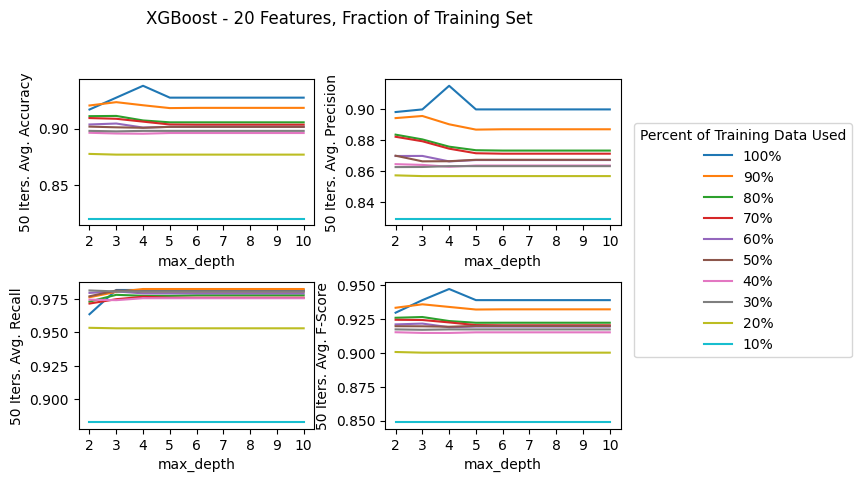

In [43]:
plot = xgb20means
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('XGBoost - 20 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 9), range(2, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 9), range(2, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 9), range(2, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 9), range(2, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [44]:
print(xgb20vars)

[array([[1.10933565e-31, 0.00000000e+00, 1.97215226e-31, 4.93038066e-32],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [0.00000000e+00, 4.43734259e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31]]), array([[2.32682292e-04, 3.01604893e-04, 1.61983471e-04, 1.52266056e-04],
       [2.46918403e-04, 3.73334802e-04, 9.04462810e-05, 1.56102754e-04],
       [2.76736111e-04, 4.12073405e-04, 6.55867769e-05, 1.71943653e-04],
       [2.76215278e-04, 4.46399381e-04, 6.55867769e-05, 1.68989489e-04],
       [2.43098958e-04, 3.85507966e-04, 6.558677

### Training models on 50 features

In [45]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
xgb50means = [] # Means of i models trained 
xgb50vars = []  # Variances of i models trained

for p in percents:
    avg_score_per_depth=[] # Store scores of models trained from depth 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_50_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_50_arr_pct), ss.transform(filtered_test_df_50_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for max_depth in range(2, 11):
            # Unique path to store models
            path = f'pkls/{dirname}/xgb50/train_{p*100:.0f}/iter_{i+1}/max_depth_{max_depth}.pkl'
            
            if os.path.exists(path):
                # Load up trained model if one exists to save time and prevent reconstruction and retraining
                clf = joblib.load(path)
            else:
                # Build and fit model
                clf = xgb.XGBClassifier(seed=random.randint(-2**31, 2**31-1), max_depth=max_depth)
                clf.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct)
            
            # Gather predictions
            preds = clf.predict(ss.transform(filtered_test_df_50_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
            
            # Save trained model to disk if one doesn't exist
            if not os.path.exists(path):
                os.makedirs(os.path.dirname(path), exist_ok=True)
                joblib.dump(clf, path, compress=3)
        
        # Store the scores for the current iteration of models with max_depth 2 to 10
        avg_score_per_depth.append(scores)
    
    avg_score_per_depth = np.array(avg_score_per_depth)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_depth, axis=0).T)
    # Store these values for plotting
    xgb50means.append(np.mean(avg_score_per_depth, axis=0))
    xgb50vars.append(np.var(avg_score_per_depth, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.9375     0.9375     0.91666667 0.92708333 0.92708333 0.92708333
  0.92708333 0.92708333 0.92708333]
 [0.90163934 0.91525424 0.8852459  0.9        0.9        0.9
  0.9        0.9        0.9       ]
 [1.         0.98181818 0.98181818 0.98181818 0.98181818 0.98181818
  0.98181818 0.98181818 0.98181818]
 [0.94827586 0.94736842 0.93103448 0.93913043 0.93913043 0.93913043
  0.93913043 0.93913043 0.93913043]]

Percent of training data used: 0.9
50 runs average score: 
[[0.93395833 0.93       0.92520833 0.92479167 0.92479167 0.92479167
  0.92479167 0.92479167 0.92479167]
 [0.90180415 0.8988399  0.89281664 0.89155893 0.89155893 0.89155893
  0.89155893 0.89155893 0.89155893]
 [0.99345455 0.98981818 0.98872727 0.98981818 0.98981818 0.98981818
  0.98981818 0.98981818 0.98981818]
 [0.94528232 0.94199075 0.93819085 0.93796033 0.93796033 0.93796033
  0.93796033 0.93796033 0.93796033]]

Percent of training data used: 0.8
50 runs average scor

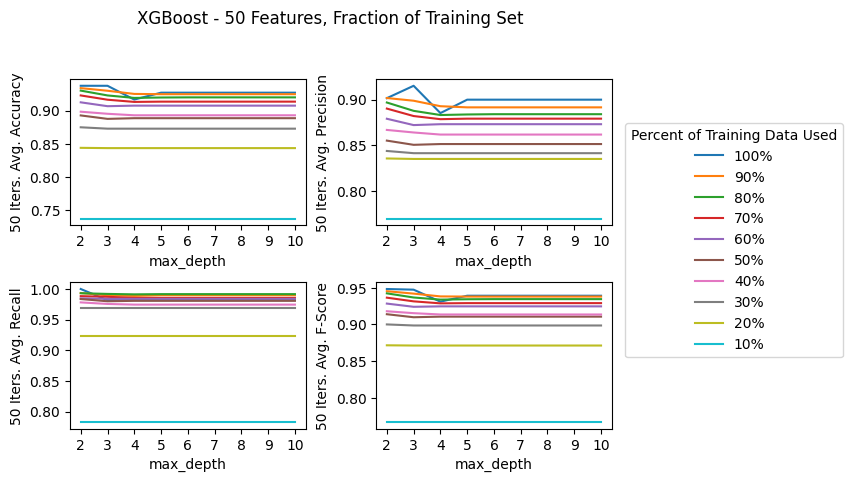

In [46]:
plot = xgb50means
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('XGBoost - 50 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 9), range(2, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 9), range(2, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 9), range(2, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 9), range(2, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [47]:
print(xgb50vars)

[array([[0.00000000e+00, 1.10933565e-31, 0.00000000e+00, 1.97215226e-31],
       [0.00000000e+00, 4.43734259e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 4.93038066e-32, 1.97215226e-31, 7.88860905e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31],
       [1.10933565e-31, 7.88860905e-31, 1.97215226e-31, 9.98402083e-31]]), array([[2.58723958e-04, 4.19981565e-04, 8.93884298e-05, 1.61301921e-04],
       [2.56250000e-04, 4.32290485e-04, 9.46776860e-05, 1.57041789e-04],
       [2.76432292e-04, 4.32700704e-04, 1.04330579e-04, 1.71432148e-04],
       [3.09418403e-04, 5.15065668e-04, 9.46776860e-05, 1.90688490e-04],
       [3.09418403e-04, 5.15065668e-04, 9.467768

## KNN

In [48]:
from sklearn.neighbors import KNeighborsClassifier

### Training models on 20 features

In [49]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
knn20means = [] # Means of i models trained 
knn20vars = []  # Variances of i models trained

for p in percents:
    avg_score_per_num_neighbors=[] # Store scores of models trained for k from 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_20_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_20_arr_pct), ss.transform(filtered_test_df_20_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for neighbors in range(1, 11):
            # Build and fit model
            clf = KNeighborsClassifier(n_neighbors=neighbors)
            clf.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct)
            
            # Gather predictions
            preds = clf.predict(ss.transform(filtered_test_df_20_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
        
        # Store the scores for the current iteration of models with k from 2 to 10
        avg_score_per_num_neighbors.append(scores)
        
        # No variance in KNN if complete training data is used, so no need to go extra iterations
        if p == 1:
            break
    
    avg_score_per_num_neighbors = np.array(avg_score_per_num_neighbors)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_num_neighbors, axis=0).T)
    # Store these values for plotting
    knn20means.append(np.mean(avg_score_per_num_neighbors, axis=0))
    knn20vars.append(np.var(avg_score_per_num_neighbors, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.95833333 0.95833333 0.94791667 0.9375     0.9375     0.94791667
  0.94791667 0.9375     0.92708333 0.9375    ]
 [0.94736842 0.94736842 0.93103448 0.92982456 0.91525424 0.93103448
  0.93103448 0.92982456 0.9137931  0.92982456]
 [0.98181818 0.98181818 0.98181818 0.96363636 0.98181818 0.98181818
  0.98181818 0.96363636 0.96363636 0.96363636]
 [0.96428571 0.96428571 0.95575221 0.94642857 0.94736842 0.95575221
  0.95575221 0.94642857 0.9380531  0.94642857]]

Percent of training data used: 0.9
50 runs average score: 
[[0.95458333 0.95395833 0.94333333 0.93854167 0.94       0.94375
  0.94104167 0.93604167 0.93458333 0.93770833]
 [0.94151035 0.94481243 0.92728157 0.92787556 0.91990064 0.93025911
  0.92554329 0.92758259 0.92005338 0.92512926]
 [0.98181818 0.97672727 0.97781818 0.968      0.98072727 0.97490909
  0.97563636 0.96363636 0.97018182 0.96981818]
 [0.96121964 0.96047516 0.95185708 0.94749351 0.94932464 0.95204155
  0.94990036

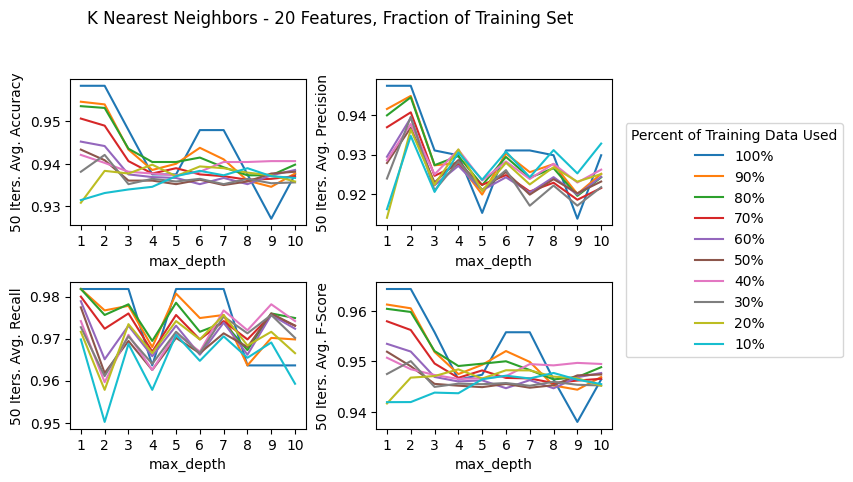

In [50]:
plot = knn20means
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('K Nearest Neighbors - 20 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 10), range(1, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 10), range(1, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 10), range(1, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 10), range(1, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [51]:
print(knn20vars)

[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[3.36805556e-05, 8.16391582e-05, 1.97215226e-31, 2.24367766e-05],
       [3.51128472e-05, 3.19059268e-05, 7.98677686e-05, 2.68418452e-05],
       [3.97569444e-05, 4.38283894e-05, 5.67272727e-05, 2.87783535e-05],
       [3.58072917e-05, 3.16102682e-05, 6.02975207e-05, 2.64260565e-05],
       [3.28125000e-05, 5.32438538e-05, 1.86446281e-05, 2.24661137e-05],
       [2.60416667e-05, 4.93540219e-06, 7.78842975e-05, 2.06702727e-05],
       [5.03906250e-05, 5.56438609e-05, 7.41818182e-05, 3.65291095e-05],
       [2.17447917e-05, 3.02131402e-05, 3.96694215e-05, 1.59191280e-05],
       [6.09375000e-05, 5.95588786e-05, 1.02611570e-04, 4.49072813e-05],
       [5.85503472e-05, 5.61979778e-05, 1.00628099e-04, 4.32324931e-05]]), array([[4.43142

### Training models on 50 features

In [52]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
knn50means = [] # Means of i models trained 
knn50vars = []  # Variances of i models trained

for p in percents:
    avg_score_per_num_neighbors=[] # Store scores of models trained for k from 2 to 10
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
        
        ss = StandardScaler()
        ss.fit(train_df_50_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_50_arr_pct), ss.transform(filtered_test_df_50_arr))
        
        scores = [] # For current iteration, store scores of trees of max_depth 2 to 10
        for neighbors in range(1, 11):
            # Build and fit model
            clf = KNeighborsClassifier(n_neighbors=neighbors)
            clf.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct)
            
            # Gather predictions
            preds = clf.predict(ss.transform(filtered_test_df_50_arr))
            
            # Gather precision, recall, and f1 score from predictions
            pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
            
            # Store these values along with accuracy for this model
            scores.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
        
        # Store the scores for the current iteration of models with k from 2 to 10
        avg_score_per_num_neighbors.append(scores)
        
        # No variance in KNN if complete training data is used, so no need to go extra iterations
        if p == 1:
            break
    
    avg_score_per_num_neighbors = np.array(avg_score_per_num_neighbors)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ')
    print(np.mean(avg_score_per_num_neighbors, axis=0).T)
    # Store these values for plotting
    knn50means.append(np.mean(avg_score_per_num_neighbors, axis=0))
    knn50vars.append(np.var(avg_score_per_num_neighbors, axis=0))
    print()

Percent of training data used: 1
50 runs average score: 
[[0.92708333 0.91666667 0.92708333 0.91666667 0.91666667 0.91666667
  0.92708333 0.91666667 0.92708333 0.92708333]
 [0.9137931  0.92727273 0.9137931  0.9122807  0.9122807  0.9122807
  0.9137931  0.9122807  0.9137931  0.9137931 ]
 [0.96363636 0.92727273 0.96363636 0.94545455 0.94545455 0.94545455
  0.96363636 0.94545455 0.96363636 0.96363636]
 [0.9380531  0.92727273 0.9380531  0.92857143 0.92857143 0.92857143
  0.9380531  0.92857143 0.9380531  0.9380531 ]]

Percent of training data used: 0.9
50 runs average score: 
[[0.92770833 0.913125   0.92479167 0.919375   0.92041667 0.92083333
  0.92541667 0.923125   0.9275     0.92791667]
 [0.91445738 0.92617517 0.91374968 0.91681078 0.91311971 0.91555134
  0.91383837 0.91765018 0.91414193 0.91595195]
 [0.964      0.92181818 0.95927273 0.94509091 0.95163636 0.94945455
  0.96036364 0.95127273 0.964      0.96254545]
 [0.93855437 0.92389306 0.93594159 0.93072072 0.93195918 0.93216301
  0.936503

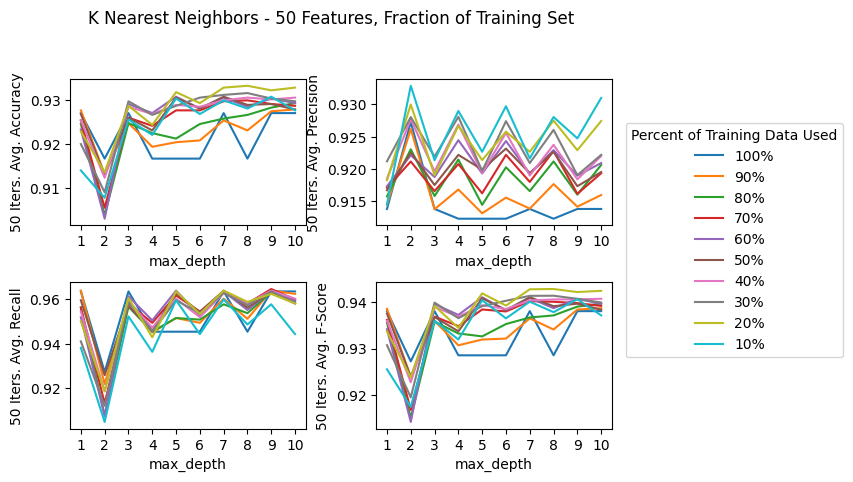

In [53]:
plot = knn50means
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.suptitle('K Nearest Neighbors - 50 Features, Fraction of Training Set')
fig.tight_layout(pad=2)

for i,p in enumerate(percents):
    ax1.plot(plot[i][:,0], label=f'{p*100:.0f}%')
ax1.set_xticks(range(0, 10), range(1, 11))
ax1.set_xlabel('max_depth')
ax1.set_ylabel('50 Iters. Avg. Accuracy')

for i,p in enumerate(percents):
    ax2.plot(plot[i][:,1], label=f'{p*100:.0f}%')
ax2.set_xticks(range(0, 10), range(1, 11))
ax2.set_xlabel('max_depth')
ax2.set_ylabel('50 Iters. Avg. Precision')

for i,p in enumerate(percents):
    ax3.plot(plot[i][:,2], label=f'{p*100:.0f}%')
ax3.set_xticks(range(0, 10), range(1, 11))
ax3.set_xlabel('max_depth')
ax3.set_ylabel('50 Iters. Avg. Recall')

for i,p in enumerate(percents):
    ax4.plot(plot[i][:,3], label=f'{p*100:.0f}%')
ax4.set_xticks(range(0, 10), range(1, 11))
ax4.set_xlabel('max_depth')
ax4.set_ylabel('50 Iters. Avg. F-Score')

handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', title='Percent of Training Data Used', bbox_to_anchor=(.95, 0.5))

In [54]:
print(knn50vars)

[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[3.21614583e-05, 1.04220593e-05, 8.58181818e-05, 2.56841558e-05],
       [1.41536458e-04, 1.33156987e-05, 4.13223140e-04, 1.25089089e-04],
       [2.73003472e-05, 5.78532108e-06, 7.35206612e-05, 2.22472502e-05],
       [2.52170139e-05, 5.38360704e-05, 6.47933884e-06, 1.68388466e-05],
       [2.93402778e-05, 5.46687088e-06, 8.74049587e-05, 2.39599315e-05],
       [3.90625000e-05, 4.98675494e-05, 6.99504132e-05, 2.92185502e-05],
       [3.19444444e-05, 5.82480734e-06, 8.84628099e-05, 2.59784737e-05],
       [5.16059028e-05, 6.47910245e-05, 1.11603306e-04, 3.91587169e-05],
       [8.50694444e-06, 5.14961663e-06, 1.97024793e-05, 6.54917983e-06],
       [1.66666667e-05, 3.06397761e-05, 1.86446281e-05, 1.16746536e-05]]), array([[1.02256

# MLP improved

In [55]:
import keras_tuner as kt
import keras
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend


2024-05-17 15:09:50.293689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 15:09:50.923332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Training models on 20 features

In [56]:
# Build model function for Keras tuner
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=20)) # 20 input features
    # Choose 1, 2, or 3 layers
    for i in range(hp.Int('layers', 1, 3)):
        # Choose anywhere from 8 to 128 nodes in a single layer
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=8, max_value=128, step=4)))
        # Add a BatchNormalization layer (scale and recenter weights)
        model.add(BatchNormalization())
        # Add relu activation
        model.add(Activation('relu'))
        # Add a dropout layer (dropout rate between 0 and 30%)
        model.add(Dropout(hp.Choice('drop_' + str(i), values=[.0, .1, .2, .3])))
    
    # Output layer
    model.add(Dense(1))
    # BatchNormalization layer
    model.add(BatchNormalization())
    # Add sigmoid activation (constrain output between 0 and 1 for binary classification)
    model.add(Activation('sigmoid'))
    # Choose learning rate for this model from among these options
    learning_rate=hp.Choice('learning_rate', values=[.01, .001, .0001])
    
    # Compile and return model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [57]:
# Allow tuner to construct models with above constraints, training on the scaled training data and watching for best validation accuracy
ss = StandardScaler()
X_train = ss.fit_transform(filtered_train_df_20_arr)
y_train = train_label_arr
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=20, factor=3, directory='kt_test20_loo1_2_3', overwrite=False)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=.2, callbacks=[stop_early])

Reloading Tuner from kt_test20_loo1_2_3/untitled_project/tuner0.json


In [58]:
# Get the model with the best validation accuracy (num_trials specifies how many top performing models to return)
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 168       
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8)                 0         
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 76)                684       
                                                                 
 batch_normalization_1 (Batc  (None, 76)               304       
 hNormalization)                                        

2024-05-17 15:09:51.885559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 15:09:51.904158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 15:09:51.904912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 15:09:51.907134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 15:09:51.907613: I tensorflow/compile

In [59]:
# Train best model 50 epochs, watch for epoch with drop in validation accuracy (potential overfitting)
history = model.fit(X_train, y_train, epochs=50, validation_split=.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(best_epoch)

Epoch 1/50
9/9 [==============================] - 1s 51ms/step - loss: 0.6186 - accuracy: 0.6769 - val_loss: 0.5529 - val_accuracy: 0.9848
Epoch 2/50
9/9 [==============================] - 0s 30ms/step - loss: 0.4264 - accuracy: 0.9115 - val_loss: 0.5136 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - 0s 30ms/step - loss: 0.4113 - accuracy: 0.9231 - val_loss: 0.5042 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - 0s 31ms/step - loss: 0.4199 - accuracy: 0.9038 - val_loss: 0.5038 - val_accuracy: 1.0000
Epoch 5/50
9/9 [==============================] - 0s 31ms/step - loss: 0.3950 - accuracy: 0.9462 - val_loss: 0.5050 - val_accuracy: 1.0000
Epoch 6/50
9/9 [==============================] - 0s 29ms/step - loss: 0.4037 - accuracy: 0.9115 - val_loss: 0.5060 - val_accuracy: 0.9848
Epoch 7/50
9/9 [==============================] - 0s 29ms/step - loss: 0.3835 - accuracy: 0.9192 - val_loss: 0.5062 - val_accuracy: 0.9848
Epoch 8/50
9/9 [===========

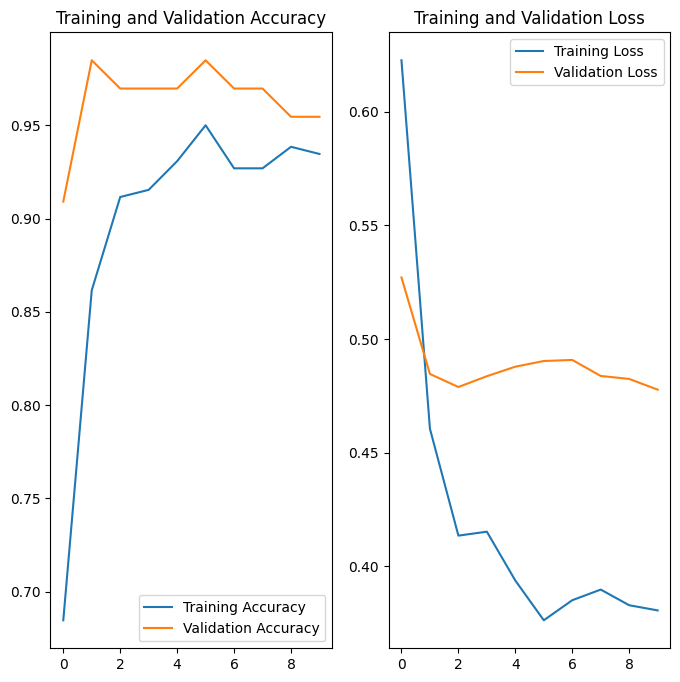

In [60]:
# Set lower bound to best_epoch to avoid underfitting
best_epoch = 10 if best_epoch < 10 else best_epoch

# Generate plot of model performance on training and validation data
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=.2, verbose=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(best_epoch)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
nn20means = [] # Means of i models trained 
nn20vars = []  # Variances of i models trained

for p in percents:
    avg_nn_acc = [] # Store scores of models trained
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)

        # Unique path to store models
        path = f'pkls/{dirname}/nn20/train_{p*100:.0f}/iter_{i+1}.keras'
        
        ss = StandardScaler()
        ss.fit(train_df_20_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_20_arr_pct), ss.transform(filtered_test_df_20_arr))
        
        if os.path.exists(path):
            # Load up trained model if one exists to save time and prevent reconstruction and retraining
            hypermodel = load_model(path)
        else:
            # Build and fit model
            hypermodel = tuner.hypermodel.build(best_hps)
            hypermodel.fit(ss.transform(train_df_20_arr_pct), train_label_arr_pct, epochs=best_epoch, validation_split=.2, verbose=0)
        
        # Gather predictions
        preds = np.round(hypermodel.predict(ss.transform(filtered_test_df_20_arr))).reshape(-1,)
        
        # Gather precision, recall, and f1 score from predictions
        pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
        
        # Store these values along with accuracy for this model
        avg_nn_acc.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
        
        # Save trained model to disk if one doesn't exist
        if not os.path.exists(path):
            os.makedirs(os.path.dirname(path), exist_ok=True)
            hypermodel.save(path)
    
    avg_nn_acc = np.array(avg_nn_acc)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ', np.mean(avg_nn_acc, axis=0))
    # Store these values for plotting
    nn20means.append(np.mean(avg_nn_acc, axis=0))
    nn20vars.append(np.var(avg_nn_acc, axis=0))
    print()

3/3 [==============================] - 0s 19ms/step
Percent of training data used: 1
50 runs average score:  [0.90645833 0.91043548 0.93127273 0.91868085]

3/3 [==============================] - 0s 5ms/step
Percent of training data used: 0.9
50 runs average score:  [0.88916667 0.90371844 0.90509091 0.90293988]

3/3 [==============================] - 0s 6ms/step
Percent of training data used: 0.8
50 runs average score:  [0.88979167 0.90465036 0.90581818 0.90235526]

3/3 [==============================] - 0s 6ms/step
Percent of training data used: 0.7
50 runs average score:  [0.87770833 0.90249401 0.88727273 0.88791602]

3/3 [==============================] - 0s 5ms/step
Percent of training data used: 0.6
50 runs average score:  [0.88125    0.90443125 0.88909091 0.89316969]

3/3 [==============================] - 0s 6ms/step
Percent of training data used: 0.5
50 runs average score:  [0.873125   0.90205259 0.87781818 0.88496297]

3/3 [==============================] - 0s 7ms/step
Percent 

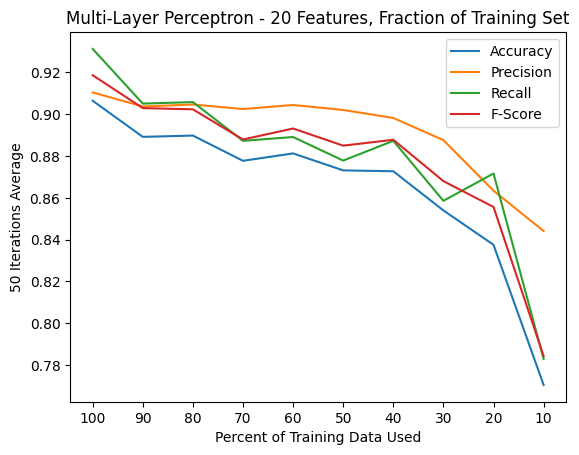

In [62]:
plt.plot(np.array(nn20means)[:,0], label='Accuracy')
plt.plot(np.array(nn20means)[:,1], label='Precision')
plt.plot(np.array(nn20means)[:,2], label='Recall')
plt.plot(np.array(nn20means)[:,3], label='F-Score')
plt.xticks(range(0, 10), [x*10 for x in range(10, 0, -1)])
plt.xlabel('Percent of Training Data Used')
plt.ylabel('50 Iterations Average')
plt.legend()
plt.title('Multi-Layer Perceptron - 20 Features, Fraction of Training Set')
plt.show()

In [63]:
print(np.array(nn20vars))

[[0.00156029 0.00159575 0.00426169 0.00144889]
 [0.00191302 0.0018174  0.0036402  0.00159063]
 [0.00218789 0.00159828 0.0069116  0.00223901]
 [0.00411376 0.0021833  0.01451901 0.0060046 ]
 [0.00388455 0.00250276 0.01015868 0.00392901]
 [0.00282418 0.00172137 0.01105507 0.00340671]
 [0.00374258 0.00388482 0.00825124 0.00293795]
 [0.00421654 0.00338242 0.01142863 0.00441524]
 [0.00648872 0.00728103 0.01960212 0.00771694]
 [0.01170556 0.0125678  0.04221369 0.0165447 ]]


### Training models on 50 features

In [64]:
# Build model function for Keras tuner
def build_model50(hp):
    model = Sequential()
    model.add(Input(shape=50)) # 50 input features
    # Choose 1, 2, or 3 layers
    for i in range(hp.Int('layers', 1, 3)):
        # Choose anywhere from 8 to 128 nodes in a single layer
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=8, max_value=128, step=4)))
        # Add a BatchNormalization layer (scale and recenter weights)
        model.add(BatchNormalization())
        # Add relu activation
        model.add(Activation('relu'))
        # Add a dropout layer (dropout rate between 0 and 30%)
        model.add(Dropout(hp.Choice('drop_' + str(i), values=[.0, .1, .2, .3])))
    
    # Output layer
    model.add(Dense(1))
    # BatchNormalization layer
    model.add(BatchNormalization())
    # Add sigmoid activation (constrain output between 0 and 1 for binary classification)
    model.add(Activation('sigmoid'))
    # Choose learning rate for this model from among these options
    learning_rate=hp.Choice('learning_rate', values=[.01, .001, .0001])
    
    # Compile and return model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [65]:
# Allow tuner to construct models with above constraints, training on the scaled training data and watching for best validation accuracy
ss = StandardScaler()
X_train = ss.fit_transform(filtered_train_df_50_arr)
y_train = train_label_arr
tuner = kt.Hyperband(build_model50, objective='val_accuracy', max_epochs=20, factor=3, directory='kt_test50_loo1_2_3', overwrite=False)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=.2, callbacks=[stop_early])

Reloading Tuner from kt_test50_loo1_2_3/untitled_project/tuner0.json


In [66]:
# Get the model with the best validation accuracy (num_trials specifies how many top performing models to return)
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 52)                2652      
                                                                 
 batch_normalization_8 (Batc  (None, 52)               208       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 52)                0         
                                                                 
 dropout_6 (Dropout)         (None, 52)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 53        
                                                                 
 batch_normalization_9 (Batc  (None, 1)                4         
 hNormalization)                                      

In [67]:
# Train best model 50 epochs, watch for epoch with drop in validation accuracy (potential overfitting)
history = model.fit(X_train, y_train, epochs=50, validation_split=.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(best_epoch)

Epoch 1/50
9/9 [==============================] - 1s 39ms/step - loss: 0.8238 - accuracy: 0.4885 - val_loss: 0.4516 - val_accuracy: 0.7879
Epoch 2/50
9/9 [==============================] - 0s 22ms/step - loss: 0.4529 - accuracy: 0.8692 - val_loss: 0.2462 - val_accuracy: 0.9545
Epoch 3/50
9/9 [==============================] - 0s 22ms/step - loss: 0.3990 - accuracy: 0.9423 - val_loss: 0.1986 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - 0s 22ms/step - loss: 0.3968 - accuracy: 0.9500 - val_loss: 0.1888 - val_accuracy: 0.9848
Epoch 5/50
9/9 [==============================] - 0s 23ms/step - loss: 0.4013 - accuracy: 0.9423 - val_loss: 0.1863 - val_accuracy: 0.9848
Epoch 6/50
9/9 [==============================] - 0s 23ms/step - loss: 0.3890 - accuracy: 0.9538 - val_loss: 0.1889 - val_accuracy: 0.9848
Epoch 7/50
9/9 [==============================] - 0s 22ms/step - loss: 0.3776 - accuracy: 0.9500 - val_loss: 0.1958 - val_accuracy: 0.9848
Epoch 8/50
9/9 [===========

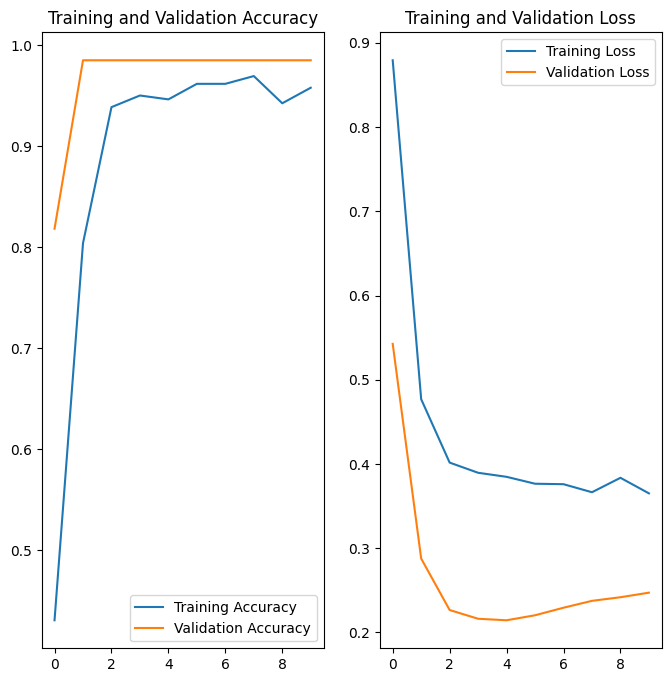

In [68]:
# Set lower bound to best_epoch to avoid underfitting
best_epoch = 10 if best_epoch < 10 else best_epoch

# Generate plot of model performance on training and validation data
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=.2, verbose=0)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(best_epoch)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
nn50means = [] # Means of i models trained 
nn50vars = []  # Variances of i models trained

for p in percents:
    avg_nn_acc = [] # Store scores of models trained
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)

        # Unique path to store models
        path = f'pkls/{dirname}/nn50/train_{p*100:.0f}/iter_{i+1}.keras'
        
        ss = StandardScaler()
        ss.fit(train_df_50_arr_pct)
        # Test for no data leakage
        assert not leakage(ss.transform(train_df_50_arr_pct), ss.transform(filtered_test_df_50_arr))
        
        if os.path.exists(path):
            # Load up trained model if one exists to save time and prevent reconstruction and retraining
            hypermodel = load_model(path)
        else:
            # Build and fit model
            hypermodel = tuner.hypermodel.build(best_hps)
            hypermodel.fit(ss.transform(train_df_50_arr_pct), train_label_arr_pct, epochs=best_epoch, validation_split=.2, verbose=0)
        
        # Gather predictions
        preds = np.round(hypermodel.predict(ss.transform(filtered_test_df_50_arr))).reshape(-1,)
        
        # Gather precision, recall, and f1 score from predictions
        pr = prfs(test_label_arr, preds, average='binary', zero_division=0.0)
        
        # Store these values along with accuracy for this model
        avg_nn_acc.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
        
        # Save trained model to disk if one doesn't exist
        if not os.path.exists(path):
            os.makedirs(os.path.dirname(path), exist_ok=True)
            hypermodel.save(path)
    
    avg_nn_acc = np.array(avg_nn_acc)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ', np.mean(avg_nn_acc, axis=0))
    # Store these values for plotting
    nn50means.append(np.mean(avg_nn_acc, axis=0))
    nn50vars.append(np.var(avg_nn_acc, axis=0))
    print()

3/3 [==============================] - 0s 4ms/step
Percent of training data used: 1
50 runs average score:  [0.910625   0.9172063  0.92836364 0.92203393]

3/3 [==============================] - 0s 4ms/step
Percent of training data used: 0.9
50 runs average score:  [0.91625    0.92464791 0.93018182 0.926894  ]

3/3 [==============================] - 0s 4ms/step
Percent of training data used: 0.8
50 runs average score:  [0.911875   0.91600825 0.932      0.92346267]

3/3 [==============================] - 0s 4ms/step
Percent of training data used: 0.7
50 runs average score:  [0.90625    0.91630806 0.92109091 0.91782301]

3/3 [==============================] - 0s 5ms/step
Percent of training data used: 0.6
50 runs average score:  [0.900625   0.91558035 0.912      0.91238815]

3/3 [==============================] - 0s 5ms/step
Percent of training data used: 0.5
50 runs average score:  [0.89479167 0.91705441 0.89854545 0.90614027]

3/3 [==============================] - 0s 4ms/step
Percent o

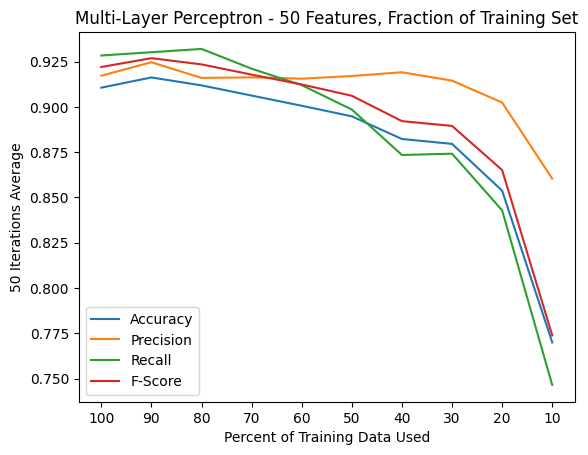

In [70]:
plt.plot(np.array(nn50means)[:,0], label='Accuracy')
plt.plot(np.array(nn50means)[:,1], label='Precision')
plt.plot(np.array(nn50means)[:,2], label='Recall')
plt.plot(np.array(nn50means)[:,3], label='F-Score')
plt.xticks(range(0, 10), [x*10 for x in range(10, 0, -1)])
plt.xlabel('Percent of Training Data Used')
plt.ylabel('50 Iterations Average')
plt.legend()
plt.title('Multi-Layer Perceptron - 50 Features, Fraction of Training Set')
plt.show()

In [71]:
print(np.array(nn50vars))

[[0.00061237 0.00034676 0.00204179 0.00054871]
 [0.00043819 0.00036598 0.00131385 0.00037305]
 [0.00064761 0.0004041  0.00151815 0.00054956]
 [0.00105469 0.00058659 0.00275848 0.00090744]
 [0.00122487 0.00090147 0.0036279  0.00111108]
 [0.00156793 0.00079397 0.00464251 0.00153775]
 [0.00237088 0.00094829 0.00913666 0.00269599]
 [0.00260052 0.00103788 0.01037805 0.00327835]
 [0.00252587 0.00253394 0.01253236 0.00306883]
 [0.01262951 0.01137577 0.03984674 0.02029213]]


# Logistic Regression

In [72]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math

### Training models on 20 features

In [73]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
lr20means = [] # Means of i models trained 
lr20vars = []  # Variances of i models trained
for p in percents:
    avg_lr_acc = [] # Store scores of models trained
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_20_arr_pct, train_label_arr_pct = filtered_train_df_20_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_20_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_20_arr, train_label_arr, train_size=p)

        ss = StandardScaler()
        pca = KernelPCA(n_components=30, kernel='rbf')
        pca_arr = pca.fit_transform(ss.fit_transform(train_df_20_arr_pct))
        # Test for no data leakage
        assert not leakage(pca_arr, pca.transform(ss.transform(filtered_test_df_20_arr)))
        
        # Build and fit model
        clf = LogisticRegression()
        clf.fit(pca_arr, train_label_arr_pct)
        
        # Gather predictions
        preds = clf.predict(pca.transform(ss.transform(filtered_test_df_20_arr)))
        
        # Gather precision, recall, and f1 score from predictions
        pr = prfs(test_label_arr, preds, average='binary')
        
        # Store these values along with accuracy for this model
        avg_lr_acc.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
    
    avg_lr_acc = np.array(avg_lr_acc)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ', np.mean(avg_lr_acc, axis=0))
    # Store these values for plotting
    lr20means.append(np.mean(avg_lr_acc, axis=0))
    lr20vars.append(np.var(avg_lr_acc, axis=0))
    print()

Percent of training data used: 1
50 runs average score:  [0.9375     0.90163934 1.         0.94827586]

Percent of training data used: 0.9
50 runs average score:  [0.93125    0.8929138  1.         0.94341291]

Percent of training data used: 0.8
50 runs average score:  [0.93020833 0.89149605 1.         0.94261334]

Percent of training data used: 0.7
50 runs average score:  [0.93145833 0.89325039 1.         0.94358868]

Percent of training data used: 0.6
50 runs average score:  [0.93       0.89172132 0.99927273 0.94240962]

Percent of training data used: 0.5
50 runs average score:  [0.926875   0.88780497 0.99890909 0.94001413]

Percent of training data used: 0.4
50 runs average score:  [0.920625   0.87998827 0.99818182 0.93522826]

Percent of training data used: 0.3
50 runs average score:  [0.92083333 0.88002151 0.99854545 0.93541124]

Percent of training data used: 0.2
50 runs average score:  [0.91395833 0.87138564 0.99818182 0.93025535]

Percent of training data used: 0.1
50 runs avera

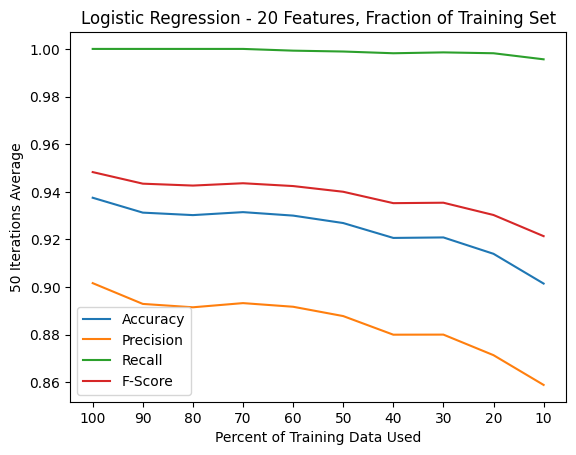

In [74]:
plt.plot(np.array(lr20means)[:,0], label='Accuracy')
plt.plot(np.array(lr20means)[:,1], label='Precision')
plt.plot(np.array(lr20means)[:,2], label='Recall')
plt.plot(np.array(lr20means)[:,3], label='F-Score')
plt.xticks(range(0, 10), [x*10 for x in range(10, 0, -1)])
plt.xlabel('Percent of Training Data Used')
plt.ylabel('50 Iterations Average')
plt.legend()
plt.title('Logistic Regression - 20 Features, Fraction of Training Set')
plt.show()

In [75]:
print(np.array(lr20vars))

[[0.00000000e+00 1.10933565e-31 0.00000000e+00 1.97215226e-31]
 [2.60416667e-05 5.07567226e-05 0.00000000e+00 1.57655422e-05]
 [4.01475694e-05 7.61168631e-05 0.00000000e+00 2.39462007e-05]
 [4.81336806e-05 9.11770194e-05 0.00000000e+00 2.86967942e-05]
 [3.92361111e-05 7.65140007e-05 1.26942149e-05 2.36293339e-05]
 [1.06293403e-04 1.99759208e-04 1.86446281e-05 6.15235050e-05]
 [1.90494792e-04 3.66642628e-04 2.97520661e-05 1.07355833e-04]
 [1.95312500e-04 3.68832271e-04 2.43305785e-05 1.10558541e-04]
 [3.37717014e-04 6.32295721e-04 2.97520661e-05 1.87860533e-04]
 [1.46358507e-03 2.20548985e-03 1.26413223e-04 7.12515127e-04]]


### Training models on 50 features

In [76]:
# Amount of training data to take (100% down to 10%)
percents = [1, .9, .8, .7, .6, .5, .4, .3, .2, .1]
lr50means = [] # Means of i models trained 
lr50vars = []  # Variances of i models trained
for p in percents:
    avg_lr_acc = [] # Store scores of models trained
    for i in range(iters):
        if p == 1:
            # Just use original data if 1 (train_test_split does not support passing 1 as argument)
            train_df_50_arr_pct, train_label_arr_pct = filtered_train_df_50_arr, train_label_arr
        else:
            # Tell train_test_split to return a given percentage of training data
            train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)
            while np.unique(train_label_arr_pct).shape[0] == 1:
                train_df_50_arr_pct, _, train_label_arr_pct, _ = train_test_split(filtered_train_df_50_arr, train_label_arr, train_size=p)

        ss = StandardScaler()
        pca = KernelPCA(n_components=30, kernel='rbf')
        pca_arr = pca.fit_transform(ss.fit_transform(train_df_50_arr_pct))
        # Test for no data leakage
        assert not leakage(pca_arr, pca.transform(ss.transform(filtered_test_df_50_arr)))
        
        # Build and fit model
        clf = LogisticRegression()
        clf.fit(pca_arr, train_label_arr_pct)
        
        # Gather predictions
        preds = clf.predict(pca.transform(ss.transform(filtered_test_df_50_arr)))
        
        # Gather precision, recall, and f1 score from predictions
        pr = prfs(test_label_arr, preds, average='binary')
        
        # Store these values along with accuracy for this model
        avg_lr_acc.append([accuracy_score(test_label_arr, preds), pr[0], pr[1], pr[2]])
    
    avg_lr_acc = np.array(avg_lr_acc)
    print('Percent of training data used:', p)
    print(iters, 'runs average score: ', np.mean(avg_lr_acc, axis=0))
    # Store these values for plotting
    lr50means.append(np.mean(avg_lr_acc, axis=0))
    lr50vars.append(np.var(avg_lr_acc, axis=0))
    print()

Percent of training data used: 1
50 runs average score:  [0.92708333 0.88709677 1.         0.94017094]

Percent of training data used: 0.9
50 runs average score:  [0.92645833 0.88625192 1.         0.93969289]

Percent of training data used: 0.8
50 runs average score:  [0.92541667 0.88533303 0.99927273 0.93884938]

Percent of training data used: 0.7
50 runs average score:  [0.925      0.8847698  0.99927273 0.93853067]

Percent of training data used: 0.6
50 runs average score:  [0.92375    0.88406729 0.99781818 0.93748373]

Percent of training data used: 0.5
50 runs average score:  [0.92       0.87980594 0.99672727 0.93456934]

Percent of training data used: 0.4
50 runs average score:  [0.91895833 0.87895512 0.996      0.93373793]

Percent of training data used: 0.3
50 runs average score:  [0.91979167 0.88099728 0.99490909 0.93433902]

Percent of training data used: 0.2
50 runs average score:  [0.91270833 0.87202193 0.99454545 0.92902361]

Percent of training data used: 0.1
50 runs avera

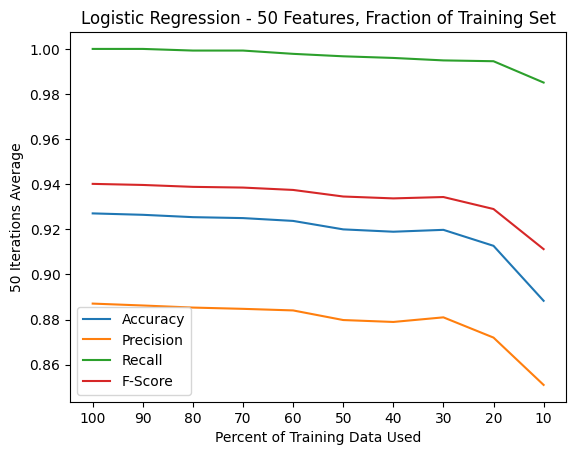

In [77]:
plt.plot(np.array(lr50means)[:,0], label='Accuracy')
plt.plot(np.array(lr50means)[:,1], label='Precision')
plt.plot(np.array(lr50means)[:,2], label='Recall')
plt.plot(np.array(lr50means)[:,3], label='F-Score')
plt.xticks(range(0, 10), [x*10 for x in range(10, 0, -1)])
plt.xlabel('Percent of Training Data Used')
plt.ylabel('50 Iterations Average')
plt.legend()
plt.title('Logistic Regression - 50 Features, Fraction of Training Set')
plt.show()

In [78]:
print(np.array(lr50vars))

[[1.10933565e-31 4.43734259e-31 0.00000000e+00 7.88860905e-31]
 [6.11979167e-06 1.11825283e-05 0.00000000e+00 3.58037682e-06]
 [1.45833333e-05 2.08188530e-05 1.26942149e-05 9.21028488e-06]
 [1.73611111e-05 2.64456820e-05 1.26942149e-05 1.08056178e-05]
 [2.79513889e-05 3.83267317e-05 3.49090909e-05 1.79465530e-05]
 [7.13541667e-05 1.19739524e-04 4.87933884e-05 4.23011582e-05]
 [7.93836806e-05 1.59153899e-04 6.99504132e-05 4.58537149e-05]
 [1.00911458e-04 2.72637953e-04 9.30909091e-05 5.61450497e-05]
 [2.51258681e-04 5.22793614e-04 8.26446281e-05 1.35019704e-04]
 [1.99670139e-03 3.53595791e-03 8.02512397e-04 8.84551916e-04]]
